In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [ ]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

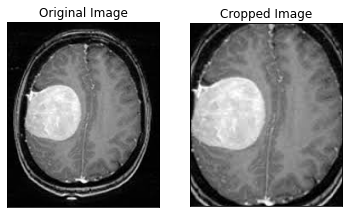

In [ ]:
ex_img = cv2.imread('/content/drive/MyDrive/Brain_Tumor/dataset/Yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [ ]:
directory="/content/drive/MyDrive/Brain_Tumor/dataset/Yes"
for filename in listdir(directory):
    print(filename)

Y67.JPG
Y167.JPG
Y51.jpg
Y39.jpg
Y12.jpg
Y91.jpg
Y75.JPG
Y116.JPG
Y163.JPG
Y60.jpg
Y250.jpg
Y55.jpg
Y105.jpg
Y36.JPG
Y26.jpg
Y253.JPG
Y103.jpg
Y96.jpg
Y29.jpg
Y2.jpg
Y11.jpg
Y154.jpg
Y97.JPG
Y249.JPG
Y166.JPG
Y256.JPG
Y102.jpg
Y101.jpg
Y31.jpg
Y185.jpg
Y168.jpg
Y246.JPG
Y81.jpg
Y252.jpg
Y53.jpg
Y71.JPG
Y38.jpg
Y180.jpg
Y164.JPG
Y62.jpg
Y21.jpg
Y254.jpg
Y82.jpg
Y114.JPG
Y248.JPG
Y54.jpg
Y169.jpg
Y255.JPG
Y58.JPG
Y165.JPG
Y157.JPG
Y16.JPG
Y92.jpg
Y86.JPG
Y32.jpg
Y19.JPG
Y113.JPG
Y193.JPG
Y28.jpg
Y61.jpg
Y115.JPG
Y7.jpg
Y3.jpg
Y187.jpg
Y244.JPG
Y14.jpg
Y188.jpg
Y182.JPG
Y258.JPG
Y107.jpg
Y76.jpg
Y195.JPG
Y92.png
Y70.jpg
Y24.jpg
Y46.jpg
Y251.JPG
Y74.jpg
Y79.jpg
Y59.JPG
Y1.jpg
Y41.jpg
Y50.JPG
Y44.JPG
Y160.JPG
Y95.jpg
Y65.JPG
Y30.jpg
Y69.jpg
Y25.jpg
Y161.JPG
Y6.jpg
Y17.jpg
Y186.jpg
Y49.JPG
Y20.jpg
Y73.jpg
Y242.JPG
Y155.JPG
Y13.jpg
Y100.JPG
Y106.jpg
Y247.JPG
Y257.jpg
Y158.JPG
Y117.JPG
Y52.jpg
Y153.jpg
Y108.jpg
Y22.jpg
Y56.jpg
Y33.jpg
Y183.jpg
Y109.JPG
Y243.JPG
Y77.jpg
Y27.jpg
Y245.jpg
Y34.jpg

In [ ]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            
#             print(directory + '/' + filename)
            
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            #image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            #print (directory[-3:])
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [ ]:
augmented_path = '/content/drive/MyDrive/Brain_Tumor/augmented_data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

print(augmented_yes)
print(augmented_no)

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

/content/drive/MyDrive/Brain_Tumor/augmented_data/yes
/content/drive/MyDrive/Brain_Tumor/augmented_data/no
Number of examples is: 1917
X shape is: (1917, 240, 240, 3)
y shape is: (1917, 1)


In [ ]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

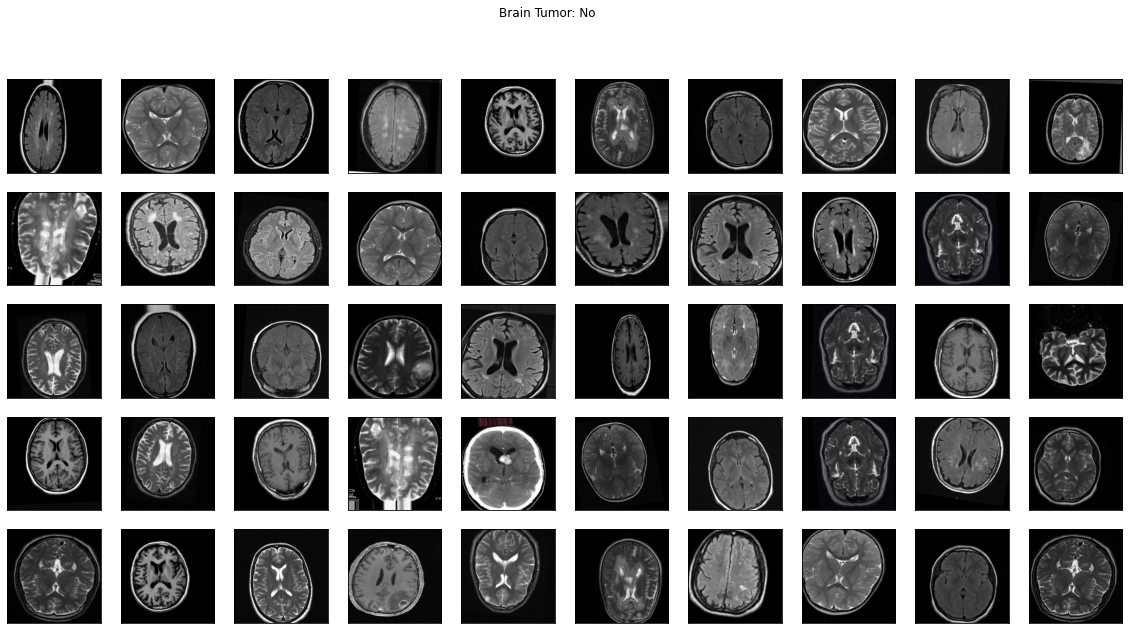

In [ ]:
plot_sample_images(X, y)

In [ ]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.20)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.2)

In [ ]:
del X
del y

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

In [ ]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [ ]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [ ]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
model = build_model(IMG_SHAPE)

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="/content/drive/MyDrive/Brain_Tumor/models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1,min_delta=50)

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[checkpoint,callback])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
48/48 [==============================] - 4s 82ms/step - loss: 0.3108 - accuracy: 0.8682 - val_loss: 0.4873 - val_accuracy: 0.7500
Epoch 2/10
48/48 [==============================] - 4s 82ms/step - loss: 0.3695 - accuracy: 0.8369 - val_loss: 0.6434 - val_accuracy: 0.7292
Elapsed time: 0:0:9.8


In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[checkpoint,callback])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[checkpoint,callback])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[checkpoint,callback])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[checkpoint,callback])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

In [ ]:
X_test.shape

In [ ]:
def load_data1(file_path,image_size):
    
    X2 = []
    
    image_width, image_height = image_size
    print(file_path)
    image = cv2.imread(file_path)
    # crop the brain and ignore the unnecessary rest part of the image
    image = crop_brain_contour(image, plot=False)
    # resize image
    image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
    # normalize values
    image = image / 255.
    # convert image to numpy array and append it to X
    X2.append(image)
    
    X2 = np.array(X2)
    
    print(f'Number of examples is: {len(X2)}')
    print(f'X shape is: {X2.shape}')
    
    return X2
    

In [ ]:
file_path='/content/drive/MyDrive/Brain_Tumor/dataset/Yes/Y1.jpg'
img=load_data1(file_path,(IMG_WIDTH, IMG_HEIGHT))

In [ ]:
# Predict from the model

ss=model.predict(img)

print(ss)

if ss[0][0]>0.5:
    output="Tumorous"
else:
    output="Non Tumorous"
        
print(output)

In [ ]:
best_model = load_model(filepath='/content/drive/MyDrive/Brain_Tumor/models/cnn-parameters-improvement-09-0.85.model')

ss=best_model.predict(img)

print(ss)

if ss[0][0]>0.5:
    output="Tumorous"
else:
    output="Non Tumorous"
        
print(output)